# check metrics

Algunos recursos utiles:
- https://www.evidentlyai.com/classification-metrics/multi-class-metrics
- https://arize.com/blog-course/f1-score/#:~:text=F1%20score%20is%20a%20measure,can%20be%20modified%20into%20F0.


In [3]:
import cv2
import os
import time
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Flatten, ConvLSTM2D, Reshape, BatchNormalization, Input, TimeDistributed
from tensorflow.keras.models import load_model, Model
from concurrent.futures import ThreadPoolExecutor

## Constants

In [9]:
emociones = ['Neutral', 'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
# IMG_SIZE = 112
# IMG_CHANNELS = 3
MAX_SEQ_LENGTH = 10
# NUM_FEATURES = 1024
# EPOCHS = 100
BATCH_SIZE=512

NUMPY_PATH = "../models/tmp/np_arr/"
MODELS_PATH = "../models/"

In [10]:
def load_model_keras(model_name):
    model = load_model(MODELS_PATH + model_name)
    return model

In [11]:
RNN_MODEL_NAME = "eche_rnn_binary_3.keras"

model = load_model_keras(RNN_MODEL_NAME)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1024)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 10, 16)               66624     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 10, 8)                800       ['lstm[0][0]']            

In [14]:
validation_ds = tf.data.Dataset.load(
    f"../datasets/processed/rnn_val_eche_{MAX_SEQ_LENGTH}_binary_v2")
validation_ds

<_LoadDataset element_spec=((TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.bool, name=None)), TensorSpec(shape=(10, 2), dtype=tf.float32, name=None))>

In [15]:
for train_data, labels in validation_ds.take(1):
    print(train_data[0].shape)
    print(train_data[1].shape)
    print(labels.shape)
    break

(10, 1024)
(10,)
(10, 2)


In [16]:
BATCH_SIZE = 512
validation_ds_batch = validation_ds.batch(BATCH_SIZE)
validation_ds_batch

<_BatchDataset element_spec=((TensorSpec(shape=(None, 10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)), TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None))>

In [17]:
for validation_data, labels in validation_ds.take(1):
    print(validation_data[0])
    print(validation_data[1])
    print(labels)
    break

tf.Tensor(
[[ 0.        0.        0.       ... 11.911159  0.        0.      ]
 [ 0.        0.        0.       ... 10.817235  0.        0.      ]
 [ 0.        0.        0.       ... 10.701271  0.        0.      ]
 ...
 [ 0.        0.        0.       ... 16.142872  0.        0.      ]
 [ 0.        0.        0.       ... 13.493545  0.        0.      ]
 [ 0.        0.        0.       ... 15.86875   0.        0.      ]], shape=(10, 1024), dtype=float32)
tf.Tensor([ True  True  True  True  True  True  True  True  True  True], shape=(10,), dtype=bool)
tf.Tensor(
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]], shape=(10, 2), dtype=float32)


In [18]:
result = model.predict(validation_ds_batch.take(1))

1/1 [==============================] - 4s 4s/step


In [19]:
result.shape

(512, 10, 2)

In [20]:
result

array([[[0.06935828, 0.9306418 ],
        [0.01752366, 0.98247635],
        [0.0094498 , 0.99055016],
        ...,
        [0.00545936, 0.99454063],
        [0.00546039, 0.99453956],
        [0.00523654, 0.99476343]],

       [[0.09381054, 0.9061894 ],
        [0.02046317, 0.9795367 ],
        [0.00911433, 0.9908856 ],
        ...,
        [0.00481036, 0.99518967],
        [0.00439863, 0.99560136],
        [0.0042905 , 0.99570954]],

       [[0.07384555, 0.92615455],
        [0.01693413, 0.9830658 ],
        [0.00867532, 0.9913246 ],
        ...,
        [0.00504172, 0.99495834],
        [0.00493495, 0.995065  ],
        [0.00487885, 0.9951212 ]],

       ...,

       [[0.8484482 , 0.1515517 ],
        [0.9431213 , 0.0568786 ],
        [0.9726593 , 0.02734068],
        ...,
        [0.98978424, 0.01021571],
        [0.99008936, 0.00991057],
        [0.9914476 , 0.00855237]],

       [[0.8641414 , 0.1358586 ],
        [0.958844  , 0.04115599],
        [0.97933966, 0.02066041],
        .

In [21]:
# loss_value, accuracy = seq_model.evaluate(validation_ds_batch)
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")

## Ahora generamos las predicciones

In [21]:
predictions = model.predict(validation_ds_batch)
print(predictions.shape)

34/34 [==============================] - 3s 85ms/step
(17361, 10, 2)


In [22]:
predictions[0]

array([[0.06935828, 0.9306418 ],
       [0.01752366, 0.98247635],
       [0.0094498 , 0.99055016],
       [0.00706282, 0.9929372 ],
       [0.0059609 , 0.99403906],
       [0.00562156, 0.9943784 ],
       [0.00542767, 0.9945723 ],
       [0.00545936, 0.99454063],
       [0.00546039, 0.99453956],
       [0.00523654, 0.99476343]], dtype=float32)

In [69]:
# (173610, 7)
validation_labels = np.concatenate([labels for _, labels in validation_ds])
print(validation_labels.shape)

(173610, 2)


In [70]:
np.unique(validation_labels, axis=0)

array([[-1., -1.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]], dtype=float32)

In [73]:
from collections import Counter

# Convertir cada subarray a una tupla
tuples_arr = [tuple(row) for row in validation_labels]

# Contar las ocurrencias de cada tupla
counts = Counter(tuples_arr)

# Imprimir los resultados
for item, count in counts.items():
    print(f'{item}: {count}')

(0.0, 0.0): 84960
(1.0, 0.0): 82219
(-1.0, -1.0): 305
(0.0, 1.0): 6126


In [27]:
y_pred = np.reshape(predictions, (-1, predictions.shape[-1]))
y_pred.shape

(173610, 2)

### Ahora guardamos las predicciones

In [28]:
y_pred = np.reshape(predictions, (-1, predictions.shape[-1]))
y_pred.shape

(173610, 2)

In [29]:
np.savetxt(NUMPY_PATH + 'predictions_binary_v02.txt', y_pred, fmt='%f')
np.savetxt(NUMPY_PATH + 'validation_labels_binary_v02.txt', validation_labels, fmt='%f')

## Métricas para la binaria

In [62]:
y_pred = np.loadtxt(NUMPY_PATH + 'predictions_binary_v02.txt', dtype=float)
y_pred = y_pred.reshape((y_pred.shape[0], 2))
# y_pred = y_pred.reshape((-1, y_pred.shape[-1]))
y_pred.shape, y_pred[0]

((173610, 2), array([0.069358, 0.930642]))

In [67]:
validation_labels = np.loadtxt(NUMPY_PATH + 'validation_labels_binary_v02.txt', dtype=float)
# y_true = y_true.reshape(y_true.shape[0], 2)
y_true = np.reshape(validation_labels, (-1, validation_labels.shape[-1]))
# y_true = y_true.reshape(-1, y_true.shape[-1])
y_true.shape, y_true[0], np.unique(y_true, axis=0)

((173610, 2),
 array([0., 0.]),
 array([[-1., -1.],
        [ 0.,  0.],
        [ 0.,  1.],
        [ 1.,  0.]]))

In [33]:
# Eliminar las filas con -1 en y_true
valid_indices = np.where(np.all(y_true != -1, axis=1))
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]
                    
print(y_true.shape)
print(y_pred.shape)

(173305, 2)
(173305, 2)


In [34]:
np.where(y_true == 0)

(array([     0,      0,      1, ..., 173303, 173304, 173304]),
 array([0, 1, 0, ..., 1, 0, 1]))

In [37]:
max_indices = tf.argmax(y_pred, axis=1)
max_indices

<tf.Tensor: shape=(173305,), dtype=int64, numpy=array([1, 1, 1, ..., 0, 0, 0])>

In [38]:
binary_pred = tf.one_hot(max_indices, depth=y_pred.shape[1])
binary_pred[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>

In [39]:
# Calcular el accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_true, binary_pred)
accuracy_result = accuracy.result().numpy()

print("Accuracy:", accuracy_result)

Accuracy: 0.5273131


In [40]:
# Calcular la precisión
precision = tf.keras.metrics.Precision()
precision.update_state(y_true, binary_pred)
precision_result = precision.result().numpy()

print("Precisión:", precision_result)

Precisión: 0.28219613


In [42]:
from sklearn.metrics import precision_score

precision_class_0 = precision_score(y_true, binary_pred, pos_label=0, average='macro')
print(f"Precision for class Negative: {precision_class_0}")

precision_class_1 = precision_score(y_true, binary_pred, pos_label=1, average='macro')
print(f"Precision for class Positive: {precision_class_1}")

Precision for class Negative: 0.2521132450948674
Precision for class Positive: 0.2521132450948674


/home/nicolas/trabajo-profesional/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1569: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


### 3 classes and threshold

### True values

In [61]:
np.unique(y_true, axis=0)

array([[0., 0.],
       [0., 1.],
       [1., 0.]])

In [59]:
# Número de clases (0, 1, 2)
num_classes = 3

# Aplicar one-hot encoding
y_true_ohe = np.array([np.append(x, 0) for x in y_true])
y_true_ohe.shape, np.unique(y_true_ohe, axis=0)

((173305, 3),
 array([[0., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]))

In [60]:
np.where(y_true_ohe == 0)

(array([     0,      0,      0, ..., 173304, 173304, 173304]),
 array([0, 1, 2, ..., 0, 1, 2]))

### Pred values

In [18]:
softmax_y_pred = [[1-i[0], i[0]] for i in y_pred]
softmax_y_pred[70:90]

[[5.8000000000002494e-05, 0.999942],
 [6.300000000003525e-05, 0.999937],
 [5.100000000002325e-05, 0.999949],
 [4.199999999998649e-05, 0.999958],
 [5.100000000002325e-05, 0.999949],
 [5.100000000002325e-05, 0.999949],
 [5.2000000000052005e-05, 0.999948],
 [4.999999999999449e-05, 0.99995],
 [6.399999999995298e-05, 0.999936],
 [5.8000000000002494e-05, 0.999942],
 [0.573923, 0.426077],
 [0.511657, 0.488343],
 [0.41507700000000003, 0.584923],
 [0.534884, 0.465116],
 [0.588886, 0.411114],
 [0.561642, 0.438358],
 [0.663272, 0.336728],
 [0.682883, 0.317117],
 [0.766891, 0.233109],
 [0.633319, 0.366681]]

In [34]:
THRESHOLD = 0.65
softmax_y_pred_3_classes = []
for i in softmax_y_pred:
    if np.max(i) < THRESHOLD:
        softmax_y_pred_3_classes.append(i+[1])
    else:
        softmax_y_pred_3_classes.append(i+[0])
softmax_y_pred_3_classes[70:90]

[[5.8000000000002494e-05, 0.999942, 0],
 [6.300000000003525e-05, 0.999937, 0],
 [5.100000000002325e-05, 0.999949, 0],
 [4.199999999998649e-05, 0.999958, 0],
 [5.100000000002325e-05, 0.999949, 0],
 [5.100000000002325e-05, 0.999949, 0],
 [5.2000000000052005e-05, 0.999948, 0],
 [4.999999999999449e-05, 0.99995, 0],
 [6.399999999995298e-05, 0.999936, 0],
 [5.8000000000002494e-05, 0.999942, 0],
 [0.573923, 0.426077, 1],
 [0.511657, 0.488343, 1],
 [0.41507700000000003, 0.584923, 1],
 [0.534884, 0.465116, 1],
 [0.588886, 0.411114, 1],
 [0.561642, 0.438358, 1],
 [0.663272, 0.336728, 0],
 [0.682883, 0.317117, 0],
 [0.766891, 0.233109, 0],
 [0.633319, 0.366681, 1]]

In [35]:
max_indices = tf.argmax(softmax_y_pred_3_classes, axis=1)
max_indices

<tf.Tensor: shape=(173305,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [36]:
softmax_pred_ohe = tf.one_hot(max_indices, depth=3)
softmax_pred_ohe[0], np.unique(softmax_pred_ohe, axis=0)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>,
 array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32))

In [37]:
# Calcular el accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_true_ohe, softmax_pred_ohe)
accuracy_result = accuracy.result().numpy()

print("Accuracy:", accuracy_result)

Accuracy: 0.7555793


In [38]:
# Precisión: 0.6445573

precision = tf.keras.metrics.Precision()
precision.update_state(y_true_ohe, softmax_pred_ohe)
precision_result = precision.result().numpy()

print("Precisión:", precision_result)

Precisión: 0.6333689


In [39]:
# Precision for class Negative: 0.484929817561931
num_classes = y_true_ohe.shape[1]

for class_id in range(num_classes):
    precision = tf.keras.metrics.Precision(class_id=class_id)
    precision.update_state(y_true_ohe, softmax_pred_ohe)
    precision_result = precision.result().numpy()
    print(f"Precisión para la clase {class_id}: {precision_result}")

Precisión para la clase 0: 0.49506059288978577
Precisión para la clase 1: 0.7501367926597595
Precisión para la clase 2: 0.0


### Check convergence

In [83]:
def get_accuracy(y_true, y_pred):
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(y_true, y_pred)
    return accuracy.result().numpy()

def get_precision(y_true, y_pred):
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    return precision.result().numpy()

def get_recall(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    return recall.result().numpy()

def get_precision_for_class(y_true, y_pred, class_id):
    precision = tf.keras.metrics.Precision(class_id=class_id)
    precision.update_state(y_true, y_pred)
    return precision.result().numpy()

def get_name_for_class(class_id):
    names = {
        0: "negative",
        1: "positive",
        2: "unknown"
    }
    return names[class_id]

def get_metrics(y_true_ohe, softmax_pred, threshold):
    results = {
        "threshold": threshold
    }
    softmax_y_pred_3_classes = []
    for i in softmax_pred:
        if np.max(i) < threshold:
            softmax_y_pred_3_classes.append(i+[1])
        else:
            softmax_y_pred_3_classes.append(i+[0])

    max_indices = tf.argmax(softmax_y_pred_3_classes, axis=1)
    softmax_pred_ohe = tf.one_hot(max_indices, depth=3)
    results["accuracy"] = get_accuracy(y_true_ohe, softmax_pred_ohe)
    results["precision"] = get_precision(y_true_ohe, softmax_pred_ohe)
    results["recall"] = get_recall(y_true_ohe, softmax_pred_ohe)
    for class_id in range(y_true_ohe.shape[1]):
        results[f"precision_{get_name_for_class(class_id)}"] = get_precision_for_class(y_true_ohe, softmax_pred_ohe, class_id)
    return results

In [84]:
df = pd.DataFrame(columns=["threshold", "accuracy", "precision", "recall", "precision_positive", "precision_negative", "precision_unknown"])
for threshold in np.arange(0.5, 0.95, 0.01):
    results = get_metrics(y_true_ohe, softmax_y_pred, threshold)
    df = pd.concat([df, pd.DataFrame([results])], ignore_index=True)
    print(df.shape)
df.info()

/tmp/ipykernel_9962/3908814098.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([results])], ignore_index=True)


(1, 7)
(2, 7)
(3, 7)
(4, 7)
(5, 7)
(6, 7)
(7, 7)
(8, 7)
(9, 7)
(10, 7)
(11, 7)
(12, 7)
(13, 7)
(14, 7)
(15, 7)
(16, 7)
(17, 7)
(18, 7)
(19, 7)
(20, 7)
(21, 7)
(22, 7)
(23, 7)
(24, 7)
(25, 7)
(26, 7)
(27, 7)
(28, 7)
(29, 7)
(30, 7)
(31, 7)
(32, 7)
(33, 7)
(34, 7)
(35, 7)
(36, 7)
(37, 7)
(38, 7)
(39, 7)
(40, 7)
(41, 7)
(42, 7)
(43, 7)
(44, 7)
(45, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   threshold           45 non-null     float64
 1   accuracy            45 non-null     float32
 2   precision           45 non-null     float32
 3   recall              45 non-null     float32
 4   precision_positive  45 non-null     float32
 5   precision_negative  45 non-null     float32
 6   precision_unknown   45 non-null     float32
dtypes: float32(6), float64(1)
memory usage: 1.5 KB


In [85]:
graphs = [
    {"x": "threshold", "y": "accuracy"},
    {"x": "threshold", "y": "precision"},
    {"x": "threshold", "y": "precision_negative"},
    {"x": "threshold", "y": "precision_positive"},
    {"x": "threshold", "y": "recall"},
]

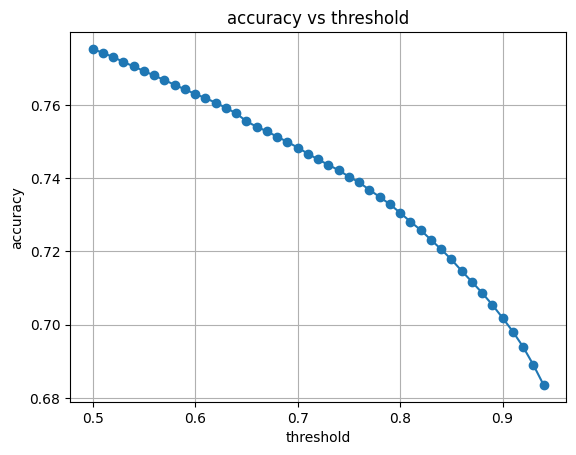

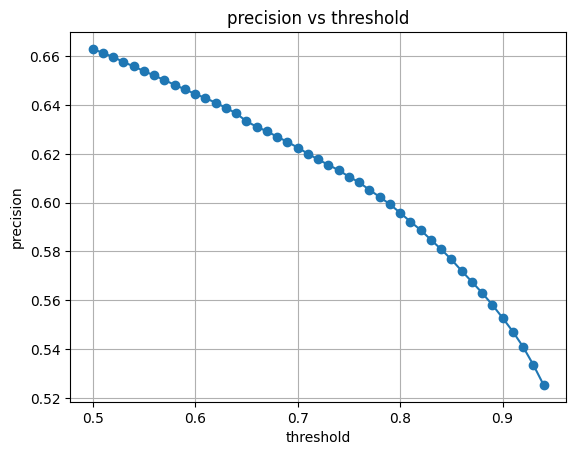

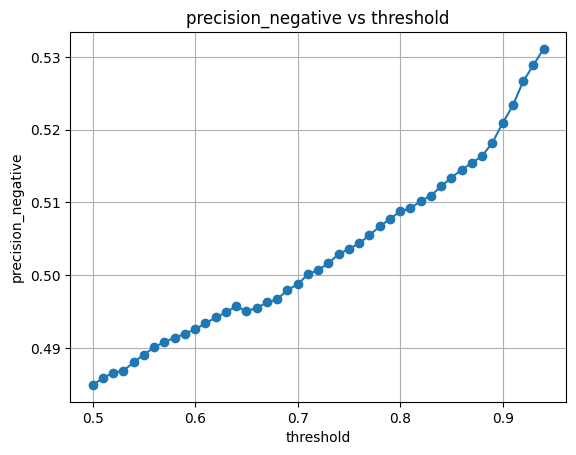

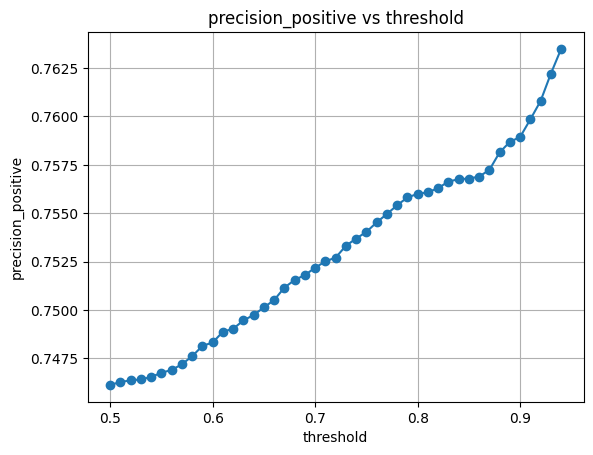

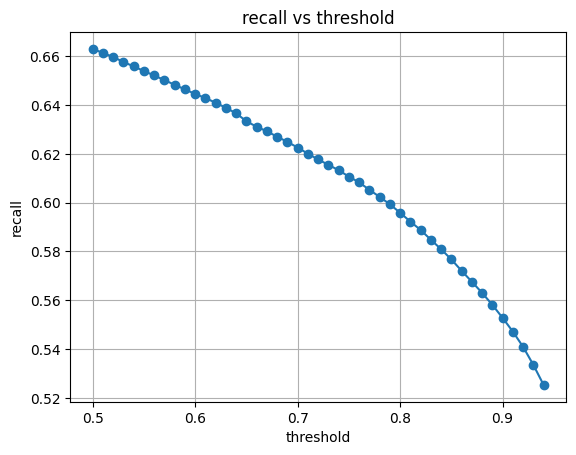

In [86]:
import matplotlib.pyplot as plt

for g in graphs:
    x_axis = g["x"]
    y_axis = g["y"]
    plt.plot(df[x_axis].tolist(), df[y_axis].tolist(), marker='o')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(f'{y_axis} vs {x_axis}')
    plt.grid(True)
    plt.show()

## Métricas a mano

In [61]:
def are_equal(arr1, arr2):
    return np.array_equal(arr1, arr2)

### accuracy

In [62]:
# 173305
assert len(y_true) == len(binary_pred)
print(len(y_true))

173305


In [63]:
# 95407
correct_predictions = 0
for correct, predicted in zip(y_true, binary_pred):
    if are_equal(correct, predicted):
        correct_predictions += 1
    #     print(f"equal: {correct}, {predicted}")
    # else:
    #     print(f"NOT equal: {correct}, {predicted}")
correct_predictions

90482

In [64]:
correct_predictions = sum([1 if are_equal(correct, predicted) else 0 for correct, predicted in zip(y_true, binary_pred)])
correct_predictions

90482

In [65]:
accuracy = correct_predictions / len(y_true)
f"accuracy is {accuracy:.4f}"

'accuracy is 0.5221'

### True and False positives

In [66]:
TP = np.zeros(7)
FP = np.zeros(7)
FN = np.zeros(7)

for correct, predicted in zip(y_true, binary_pred):
    correct_index = np.where(correct == 1)[0]
    predicted_index = np.where(predicted == 1)[0]
    if are_equal(correct, predicted):
        # prediction was correct
        TP[correct_index] += 1
    else:
        # prediction was incorrect
        FP[predicted_index] += 1
        FN[correct_index] += 1
print(f"TP is {TP}")
print(f"FP is {FP}")
print(f"FN is {FN}")

TP is [5.2628e+04 4.7000e+02 4.3000e+01 8.7000e+01 2.8972e+04 2.7200e+03
 5.5620e+03]
FP is [17306.  2450.  2191.  2209. 40288.  6935. 11444.]
FN is [29591.  5656.  4856.  8321.  5376. 22371.  6652.]


In [67]:
assert TP.sum() == correct_predictions

In [68]:
def get_precision(true_positives, false_positives):
    return true_positives / (true_positives + false_positives)

def get_recall(true_positives, false_negatives):
    return true_positives / (true_positives + false_negatives)

def get_f1(precision, recall):
    return 2 * precision * recall / (precision + recall)

In [69]:
F1s = []

for i, _ in enumerate(TP):
    print(f"metricas para {emociones[i]}")
    TPi = TP[i]
    FPi = FP[i]
    FNi = FN[i]
    Precisioni = get_precision(TPi, FPi)
    Recalli = get_recall(TPi, FNi)
    if Recalli != 0:
        F1i = get_f1(Precisioni, Recalli)
    else:
        F1i = 0
    F1s.append(F1i)
    print(f"Precision is {Precisioni:.4f}")
    print(f"Recalli is {Recalli:.4f}")
    print(f"F1i is {F1i:.4f}")

print(f"Macro average F1 is {(sum(F1s) / len(F1s))}")

metricas para Neutral
Precision is 0.7525
Recalli is 0.6401
F1i is 0.6918
metricas para Anger
Precision is 0.1610
Recalli is 0.0767
F1i is 0.1039
metricas para Disgust
Precision is 0.0192
Recalli is 0.0088
F1i is 0.0121
metricas para Fear
Precision is 0.0379
Recalli is 0.0103
F1i is 0.0163
metricas para Happiness
Precision is 0.4183
Recalli is 0.8435
F1i is 0.5593
metricas para Sadness
Precision is 0.2817
Recalli is 0.1084
F1i is 0.1566
metricas para Surprise
Precision is 0.3271
Recalli is 0.4554
F1i is 0.3807
Macro average F1 is 0.27436110007695125
